In [3]:
import pandas as pd

In [4]:
water_quality = pd.read_csv('../Class_Data/water quality.csv')
water_quality['is_safe'] = water_quality['is_safe'].map({'Yes': 1, 'No': 0})

The nearest neighbours technique is a function used for unsupervised and supervised based learning, where the distance to the closes neighbours is measured. One can perform learning based on the number of points or *k-nearest-learning*, or on the local density of the points, know as *radius-based neighbour learning*.

Right now, we will only be touching on the Supervised appproach and looking at KNN for classification. 

### Classification
Neighbours-based classification is a type of *instance-based learning* or *non-generalizing learning*. Aka it does not create a general internal model (lazy learning). Classification is calculated based on majority vote.

Within scikit, we have the KNeighborsClassifier and the RadiusNeighboursClassifier.

Weights can be adjusted using the weights keyword. By default, the model uses 'uniform' weights; 'distance' assigns weights proportional to the inverse of the distance from the query point. One can also use a user-defined function of the distance to compute the weights. 

### Regression
Similarly, for continuous data, one can use the Regression method, this works identically to the classification method.

## KNeighborsClassifier

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

X = water_quality.drop('is_safe', axis=1)
y = water_quality['is_safe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3
)

clf = GridSearchCV(
    estimator=pipe,
    param_grid={
        'classifier__n_neighbors': [i for i in range(3, 20, 2)],
        'classifier__weights': ['uniform', 'distance']
    },
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [54]:
clf.best_params_

{'classifier__n_neighbors': 17, 'classifier__weights': 'uniform'}

In [56]:
clf.best_score_

np.float64(0.831443141254462)

Test Accuracy 0.8198992443324937


<Figure size 500x500 with 0 Axes>

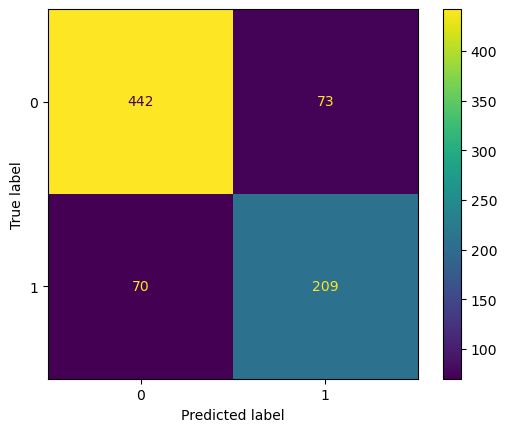

In [57]:
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

print("Test Accuracy", accuracy_score(y_test, y_pred))

plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_test,
        y_pred
    ),
    display_labels=clf.classes_
)
disp.plot()
plt.show()

<Figure size 500x500 with 0 Axes>

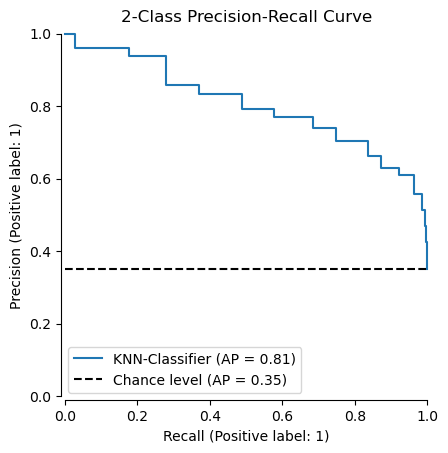

In [61]:
plt.figure(figsize=(5, 5))
disp = PrecisionRecallDisplay.from_estimator(
    estimator=clf,
    X=X_test,
    y=y_test,
    plot_chance_level=True,
    name='KNN-Classifier',
    despine=True
)
_ = disp.ax_.set_title("2-Class Precision-Recall Curve")
plt.show()

**Note**, it is important to use the from estimator method or to use the predicted probablities to calculate the roc_auc score, because if the results are used, the binary classifications of attributes will lead to inaccuracies in the calculations.

In [62]:
print("ROC AUC Score:", 
      roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

ROC AUC Score: 0.9028291053345862


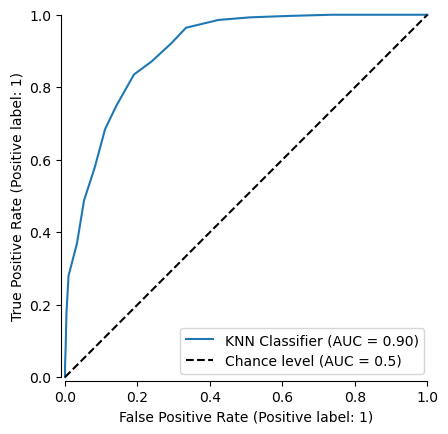

In [63]:
RocCurveDisplay.from_estimator(
    estimator=clf,
    X=X_test,
    y=y_test,
    despine=True,
    plot_chance_level=True,
    name='KNN Classifier'
    )

## KNeighborsRegressor

In [ ]:
midcity = pd.read_csv('../Class_Data/midcity.csv')

,Home,Nbhd,Offers,SqFt,Brick,Bedrooms,Bathrooms,Price
0,1,2,2,1790,No,2,2,114300
1,2,2,3,2030,No,4,2,114200
2,3,2,1,1740,No,3,2,114800
3,4,2,3,1980,No,3,2,94700
4,5,2,3,2130,No,3,3,119800
...,...,...,...,...,...,...,...,...
123,124,2,3,1900,Yes,3,3,119700
124,125,2,3,2160,Yes,4,3,147900
125,126,1,2,2070,No,2,2,113500
126,127,3,1,2020,No,3,3,149900


In [72]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [78]:
preprocessor = ColumnTransformer([
    ('min_max_normalizer', MinMaxScaler(), ['Nbhd', 'Offers', 'Bedrooms', 'Bathrooms']),
    ('Zscore_normalizer', StandardScaler(), ['SqFt']),
    ('label_binarizer', OneHotEncoder(drop='if_binary'), ['Brick'])
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn_regressor', KNeighborsRegressor())
])

# Use MAPE (based of relative error)
clf = GridSearchCV(
    estimator=pipe,
    param_grid={
        'knn_regressor__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
        'knn_regressor__weights': ['uniform', 'distance']
    },
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    return_train_score=True
)

X = midcity.drop(['Home', 'Price'], axis=1)
y = midcity['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=1992
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [81]:
clf.best_params_

{'knn_regressor__n_neighbors': 5, 'knn_regressor__weights': 'distance'}

In [80]:
-clf.best_score_

np.float64(0.0929051371676833)

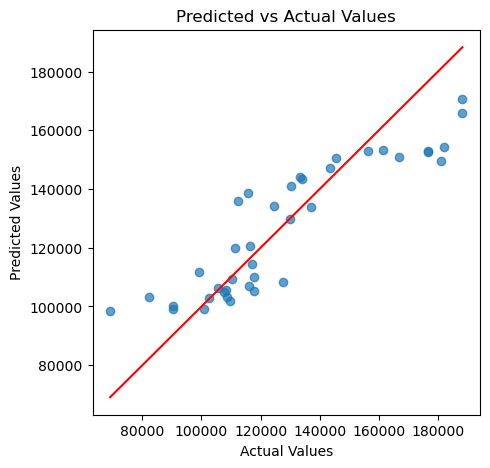

R^2 Score: 0.775548973270493


In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

print("R^2 Score:", r2_score(y_test, y_pred))

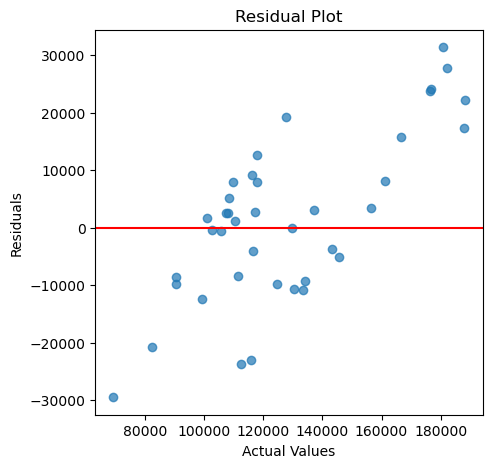

In [93]:
residuals = y_test - y_pred

plt.figure(figsize=(5, 5))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='r')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residual plot is not nicely distributed suggesting a linear relationship. Due to this, I think I will segway into learning a bit more data processing that requires understanding the properties of the data just a bit more.